# **ARIMA forecasting for Corporación Favorita Grocery Sales**

# **1️⃣ Notebook-Beschreibung**

# 📈 Zeitreihen-Prognose mit ARIMA & Darts

Dieses Notebook führt Schritt für Schritt durch den Aufbau und die Evaluierung eines klassischen **ARIMA-Modells** (AutoRegressive Integrated Moving Average). Wir nutzen hierfür die **Darts-Bibliothek** und konzentrieren uns auf eine einzelne tägliche Verkaufsreihe (Store-Item-Paar) aus dem *Corporación Favorita Grocery Sales Forecasting*-Datensatz.

### 🎯 Unsere Lernziele

Wir werden den gesamten Prozess der statistischen Modellierung durchlaufen:

* **Datenvorbereitung** 🛠️: Aufbereitung der Rohdaten und Filterung auf eine spezifische Einzelzeitreihe.
* **Darts-Integration** 🎯: Umwandlung der Daten in ein `TimeSeries`-Objekt, das Standardformat der Darts-Bibliothek.
* **Stationaritäts-Check** 📊: Überprüfung der Zeitreihe und Bestimmung des Differenzierungsgrades , um die Reihe stabil zu machen.
* **Modell-Identifikation** 🔍: Nutzung von **ACF** (Autokorrelationsfunktion) und **PACF** (Partielle Autokorrelationsfunktion), um die optimalen Ordnungen für den AR-Teil () und den MA-Teil () zu bestimmen.
* **Training & Validierung** 🚀: Trainieren des ARIMA-Modells auf einem Trainingsdatensatz und anschließende Bewertung der Prognosegüte anhand von Testdaten.

# **2️⃣. 🛠️Einrichtung und Installation des Notebooks**

## 2.1. 🛠️ Installation der Abhängigkeiten

In [25]:
%pip install -q plotly seaborn # Für interaktive und erweiterte Visualisierungen
%pip install -q ipywidgets # Für interaktive Widgets im Colab-Notebook

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [26]:
# Importieren der installierten Bibliotheken für die Zeitreihenanalyse
import darts  # Hauptbibliothek für Zeitreihenmodelle (ARIMA, Prophet, etc.) und Zeitreihenoperationen
import statsmodels  # Traditionelle statistische Modelle für Zeitreihenanalyse und -tests
import statsforecast  # Optimierte statistische Prognosealgorithmen für große Datensätze
import matplotlib.pyplot as plt  # Für grundlegende Visualisierungen
import pandas as pd  # Für Datenmanipulation und -analyse   

# Überprüfung der installierten Versionen - wichtig für Reproduzierbarkeit und Kompatibilität
print(f"Darts version: {darts.__version__}")  # Zeigt die installierte Version der Darts-Bibliothek
print(f"Statsmodels version: {statsmodels.__version__}")  # Zeigt die Version von Statsmodels
print(f"StatsForecast version: {statsforecast.__version__}")  # Zeigt die Version von StatsForecast

Darts version: 0.40.0
Statsmodels version: 0.14.6
StatsForecast version: 2.0.3


## 2.2. ⚙️ Importe und Konfiguration

In [27]:
# 📦 Standard-Bibliotheken importieren
import os  # 🖥️ Betriebssystem-Interaktion (Dateipfade, Verzeichnisse)
import pandas as pd  # 📊 Datenanalyse und -manipulation (DataFrames)
import numpy as np  # 🔢 Numerische Berechnungen (Arrays, Mathematik)

import sys  # 🐍 System-spezifische Parameter und Funktionen
from pathlib import Path  # 📁 Objektorientierte Dateipfad-Manipulation

# 1️⃣ Projekt-Root-Verzeichnis dynamisch bestimmen (ein Ebene nach oben)
# 🏠 Aktuelles Arbeitsverzeichnis abrufen
cwd = os.getcwd()
# 📍 Aktuelles Verzeichnis ausgeben
print("📍Current working directory:", cwd)

# 🔝 Projekt-Root = Übergeordnetes Verzeichnis des aktuellen Verzeichnisses
project_root = os.path.abspath(os.path.join(cwd, ".."))
# 📍 Projekt-Root-Pfad ausgeben
print("🏠 Project root:", project_root)

# 2️⃣ Projekt-Root zu sys.path hinzufügen (für Python-Imports)
# 🔍 Prüfen, ob Projekt-Root noch nicht in sys.path enthalten ist
if project_root not in sys.path:
    sys.path.insert(0, project_root)  # 📌 Am Anfang der Suchpfadliste einfügen

# ✅ Bestätigung der Hinzufügung ausgeben
print("📌 Project root added to sys.path:", project_root)

📍Current working directory: /Users/sadiqqais/Masterschool/Projekt/time_series_projekt/notebooks
🏠 Project root: /Users/sadiqqais/Masterschool/Projekt/time_series_projekt
📌 Project root added to sys.path: /Users/sadiqqais/Masterschool/Projekt/time_series_projekt


In [28]:
from utils import load_csv, save_csv, load_data_filtered_by_date, load_filtered_csv
from paths import get_path# 🔧 Eigene Utility-Funktionen aus dem lokalen Modul 'utils' importieren
# 📥 Funktion zum Laden von CSV-Dateien
from utils import load_csv

# 💾 Funktion zum Speichern von DataFrames als CSV-Dateien
from utils import save_csv

# 📅 Funktion zum Laden und Filtern von Daten basierend auf Datumsbereich
from utils import load_data_filtered_by_date

# 🔍 Funktion zum Laden gefilterter CSV-Daten (wahrscheinlich mit weiteren Filtern)
from utils import load_filtered_csv

# 🗺️ Pfadverwaltungsfunktionen aus dem lokalen Modul 'paths' importieren
# 📍 Funktion zum Abrufen von Dateipfaden (wahrscheinlich Projektpfade)
from paths import get_path

# **3️⃣ 📂 Datenzugriff und Laden**

## 3.1. 📂 Pfadkonfiguration

In [29]:
# 🗂️ Basis-Projektverzeichnis im Google Drive festlegen
# 🏠 Hauptordner für das gesamte Zeitreihenprojekt abrufen
base_dir = get_path("root")

# 📂 Unterverzeichnisse für die strukturierte Datenorganisation definieren
# 🧱 Rohdaten-Verzeichnis (originale, unbearbeitete Daten)
raw_subdir = get_path("raw")

# 🧹 Bereinigte Daten-Verzeichnis (von Fehlern/Unstimmigkeiten bereinigt)
cleaner_subdir = get_path("cleaner")

# 🧠 Feature-Engineering-Daten-Verzeichnis (abgeleitete Merkmale)
feature_subdir = get_path("features")

# 🔍 Gefilterte Daten-Verzeichnis (nach bestimmten Kriterien gefiltert)
filtered_subdi = get_path("filtered")

# 📄 Dateiname der bereinigten Trainingsdaten festlegen
# 🚂 CSV-Datei mit den vorverarbeiteten Trainingsdaten
filename = "train_cleaned.csv"

## 3.2 🧼 Laden der bereinigten Trainingsdaten

Assuming you already created a cleaned training file (e.g. train_cleaned.csv) in a previous notebook.

In [30]:
# 📥 Lädt die bereinigte CSV-Datei in einen Pandas DataFrame

# 📂 Name des Quellordners (hier "features" für vorverarbeitete Daten mit Merkmalen)
folder_name = "features"

# 🏷️ Name der Tabelle/Datei (ohne Dateierweiterung) im Quellordner
table_name = "train_features"

# 🔎 Filterparameter für die Datenauswahl
filters = {
    "MAX_DATE": "2014-04-01",  # ⏱️ Maximales Datum (Daten bis einschließlich dieses Datums)
    "STORE_IDS": [24],         # 🏪 Liste der Shop-IDs (hier nur Shop 24)
    "ITEM_IDS": [105577]       # 🏷️ Liste der Artikel-IDs (hier nur Artikel 105577)
}

# 📁 Zielordner für die gefilterten Daten (wird vermutlich für zwischengespeicherte gefilterte Daten verwendet)
filter_folder = "filtered"

# 🔄 Flag, ob Neuberechnung erzwungen werden soll (False = verwende vorhandene gefilterte Datei)
force_recompute = False

# 📊 Aufruf der Funktion zum Laden der gefilterten Daten
df_cleaned = load_filtered_csv(
    folder_name=folder_name,      # 📂 Quellordner
    table_name=table_name,        # 🏷️ Quelltabelle
    filters=filters,              # 🔎 Anzuwendende Filter
    filter_folder=filter_folder,  # 📁 Zielordner für Cache
    force_recompute=force_recompute,  # 🔄 Neuberechnungsflag
)

⚡ Loading existing filtered dataset: train_features__MAXDATE-2014-04-01__STORE-24__ITEM-105577.csv

📅 Date Range:
   Start: 2013-01-02
   End:   2014-04-01
   Days:  455


# **4️⃣ Filter to a single store–item series**
We focus on one store and one item to get a clean univariate daily series.

## 4.1. Define store and item

In [31]:
# 🎯 Auswahl eines spezifischen Stores und Items für die Zeitreihenanalyse

# 🏪 Liste der Store-IDs (hier nur Store 24) - kann bei Bedarf angepasst werden
store_ids = [24]

# 🏷️ Liste der Item-IDs (hier nur Item 105577) - kann bei Bedarf angepasst werden
item_ids = [105577]

# ⏱️ Begrenzung der Daten auf einen bestimmten Zeitraum
# 📅 Maximales Datum im Format YYYY-MM-DD (hier: alle Daten vor dem 1. April 2014)
max_date = "2014-04-01"

## 4.2. Filter the DataFrame

In [32]:
# 🔎 DataFrame nach ausgewählten Store- und Item-IDs sowie Zeitraum filtern

# 🎯 Anwendung der Filterkriterien auf den bereinigten DataFrame
df_filtered = df_cleaned[
    (df_cleaned["store_nbr"].isin(store_ids)) &  # 🏪 Filtert nur Store 24 (aus store_ids-Liste)
    (df_cleaned["item_nbr"].isin(item_ids)) &    # 🏷️ Filtert nur Item 105577 (aus item_ids-Liste)
    (df_cleaned["date"] < max_date)              # ⏱️ Filtert Daten VOR dem 1. April 2014
].copy()  # 📋 Erstellt eine unabhängige Kopie zur Vermeidung von SettingWithCopy-Warnungen

# 👁️ Zeigt die ersten 5 Zeilen des gefilterten DataFrames an (Überblick über die Daten)
df_filtered.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,z_score,year,month,day,day_of_week,unit_sales_3d_mean,unit_sales_7d_mean,unit_sales_14d_mean,unit_sales_30d_mean,unit_sales_3d_median,unit_sales_7d_median,unit_sales_14d_median,unit_sales_30d_median
0,24,105577,2013-01-02,18792.0,1.0,False,-0.83151,2013,1,2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,24,105577,2013-01-03,59694.0,1.0,False,-0.83151,2013,1,3,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,24,105577,2013-01-04,99666.0,1.0,False,-0.83151,2013,1,4,4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,24,105577,2013-01-05,140807.0,1.0,False,-0.83151,2013,1,5,5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,24,105577,2013-01-06,182802.0,1.0,False,-0.83151,2013,1,6,6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


# **5️⃣ Prepare the time series for Darts**

## 5.1. Aggregate to daily sales and set index

In [33]:
# 📅 Datumsspalte in DateTime-Format umwandeln (falls noch nicht in diesem Format)
# 🔄 Sicherstellt, dass die Datumsspalte als datetime-Objekt erkannt wird
df_filtered["date"] = pd.to_datetime(df_filtered["date"])

# 📊 Gruppiere nach Datum und summiere die Verkaufszahlen (unit_sales) für jeden Tag
# 🔢 Aggregation der täglichen Verkäufe (falls mehrere Transaktionen pro Tag vorhanden sind)
df_filtered = (
    df_filtered
    .groupby("date")["unit_sales"]  # 📅 Gruppierung nach Datum, Auswahl der Verkaufsspalte
    .sum()  # ➕ Summierung der Verkäufe pro Tag
    .reset_index()  # 🔄 Zurücksetzen des Index, damit 'date' wieder eine Spalte wird
)

# 🗓️ Setze 'date' als Index des DataFrames (notwendig für viele Zeitreihenoperationen)
# 📈 Inplace=True ändert den DataFrame direkt, ohne neue Variable zuzuweisen
df_filtered.set_index("date", inplace=True)

# 👀 Zeige die ersten 5 Einträge der aggregierten Zeitreihe (tägliche Gesamtverkäufe)
df_filtered.head()

,unit_sales
date,
2013-01-02,1.0
2013-01-03,1.0
2013-01-04,1.0
2013-01-05,1.0
2013-01-06,1.0


## 5.2. Reindex to full daily calendar and fill gaps

In [34]:
# 🗓️ Erstelle einen vollständigen täglichen Index von Mindest- bis Maximaldatum
# 📅 Stellt sicher, dass jeder Tag im Zeitraum vertreten ist (auch ohne Verkäufe)
full_index = pd.date_range(
    start=df_filtered.index.min(),  # ⬇️ Frühestes Datum in den Daten
    end=df_filtered.index.max(),    # ⬆️ Spätestes Datum in den Daten
    freq="D"                        # 📆 Tägliche Frequenz (D = Day/Tag)
)

# 🔄 Reindiziere den DataFrame mit dem vollständigen Index
# ➕ Fügt fehlende Tage als neue Zeilen mit NaN-Werten hinzu
df_filtered = df_filtered.reindex(full_index)

# 🔧 Fülle fehlende Tage (NaN) mit Verkaufswert 0
# 🏷️ Annahme: An Tagen ohne Eintrag fanden keine Verkäufe statt
df_filtered["unit_sales"] = df_filtered["unit_sales"].fillna(0)

# 🏷️ Setze den Indexnamen auf "date" (für Konsistenz in der Datenstruktur)
df_filtered.index.name = "date"

# 👀 Zeige die ersten 5 Einträge des vollständig indizierten DataFrames
df_filtered.head()

,unit_sales
date,
2013-01-02,1.0
2013-01-03,1.0
2013-01-04,1.0
2013-01-05,1.0
2013-01-06,1.0


## 5.3. Convert to Darts TimeSeries

In [35]:
# 📦 Importiere Darts TimeSeries-Klasse für Zeitreihenoperationen
from darts import TimeSeries

# 🔢 NumPy wird möglicherweise für numerische Operationen benötigt
import numpy as np

# 🎯 Erstelle ein Darts TimeSeries-Objekt aus der Pandas Series der täglichen Verkaufszahlen
# 📈 Konvertiert den Pandas DataFrame/Series in das Darts-interne Zeitreihenformat
series = TimeSeries.from_series(df_filtered["unit_sales"])

# 📊 Zeige eine Zusammenfassung der erstellten Zeitreihe an
print("📊 Zeitreihen-Zusammenfassung:")
print(f"Länge: {len(series)}")  # 🔢 Anzahl der Zeitpunkte in der Reihe
print(f"Zeitbereich: {series.time_index[0]} bis {series.time_index[-1]}")  # ⏱️ Start- und Enddatum
print(f"Frequenz: {series.freq}")  # 📅 Zeitliche Auflösung (hier täglich)

📊 Zeitreihen-Zusammenfassung:
Länge: 454
Zeitbereich: 2013-01-02 00:00:00 bis 2014-03-31 00:00:00
Frequenz: <Day>


# **6️⃣ Exploratory visualization**

## 6.1. Plot the daily sales series

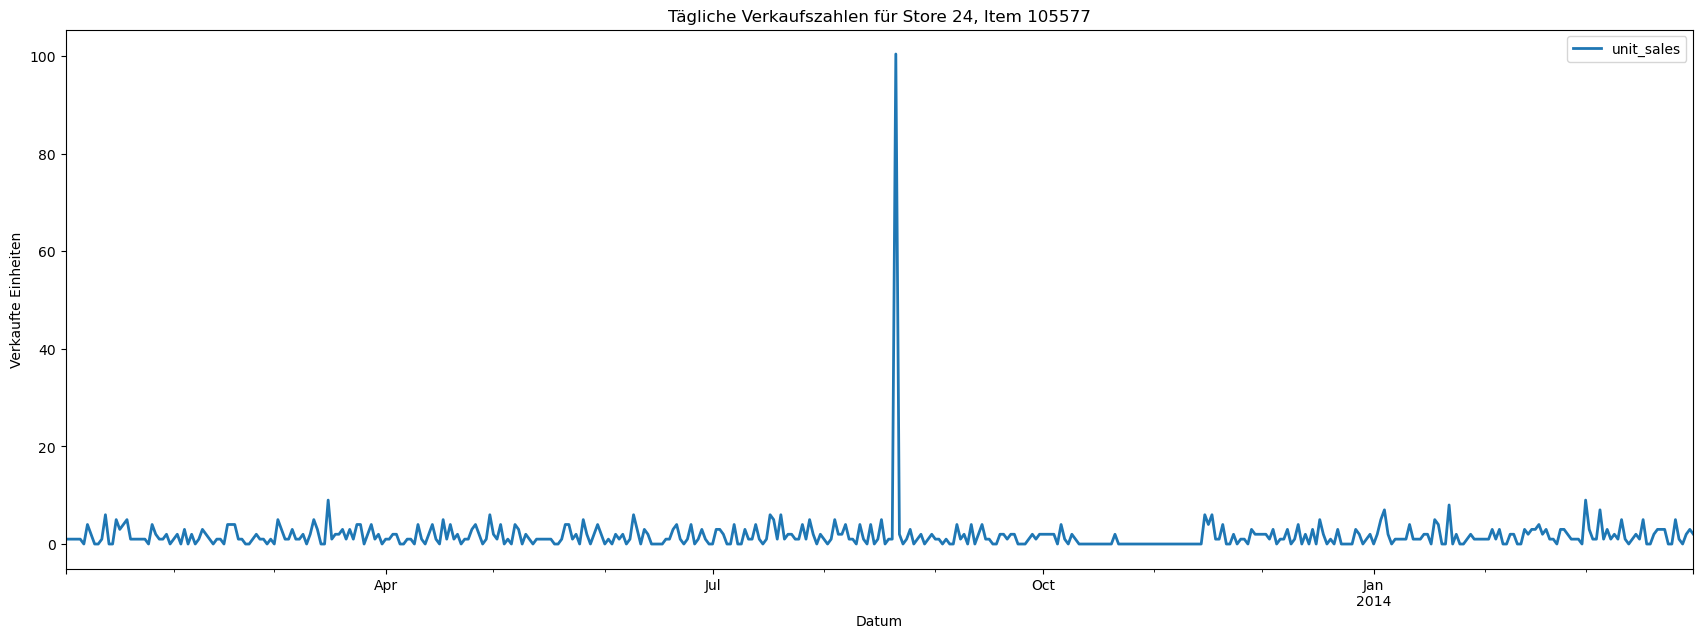

In [36]:
# 📊 Erstelle eine Figure mit einer Größe von 21x7 Zoll (breit genug für lange Zeitreihen)
# 🖼️  Breite Figure für bessere Darstellung langer Zeitreihen
plt.figure(figsize=(21, 7))

# 📈 Plotte die Zeitreihe mit der integrierten .plot()-Methode von Darts
# 🎨 Darts-eigene Plot-Funktion für TimeSeries-Objekte
series.plot()

# 🏷️ Titel und Achsenbeschriftungen setzen
plt.title("Tägliche Verkaufszahlen für Store 24, Item 105577")  # 📝 Überschrift des Plots
plt.xlabel("Datum")  # 🗓️ Beschriftung der x-Achse
plt.ylabel("Verkaufte Einheiten")  # 📦 Beschriftung der y-Achse

# 👀 Plot anzeigen
plt.show()

1. **Gezielte Prognose:** Wir analysieren eine spezifische Zeitreihe (Store 24, Item 105577), um die Dynamik einzelner Produkte präzise zu verstehen.
2. **Markteinflüsse:** Zusätzliche Feiertage treiben den Umsatz massiv an, während nicht-verderbliche Waren das Gesamtsortiment dominieren 📊.
3. **Wachstumsdynamik:** Die Daten zeigen einen klaren langfristigen Aufwärtstrend mit starken wöchentlichen und saisonalen Rhythmen 📈.
4. **Statistische Hürden:** Da die Zeitreihe nicht stationär ist und schwankende Mittelwerte aufweist, ist eine Differenzierung für das ARIMA-Modell zwingend erforderlich 🛠️.
5. **Modell-Setup:** Die hohe Autokorrelation bestätigt, dass vergangene Verkäufe ein exzellenter Signalgeber für zukünftige Prognosen sind ✨.

## 6.2. Rolling mean to inspect trend

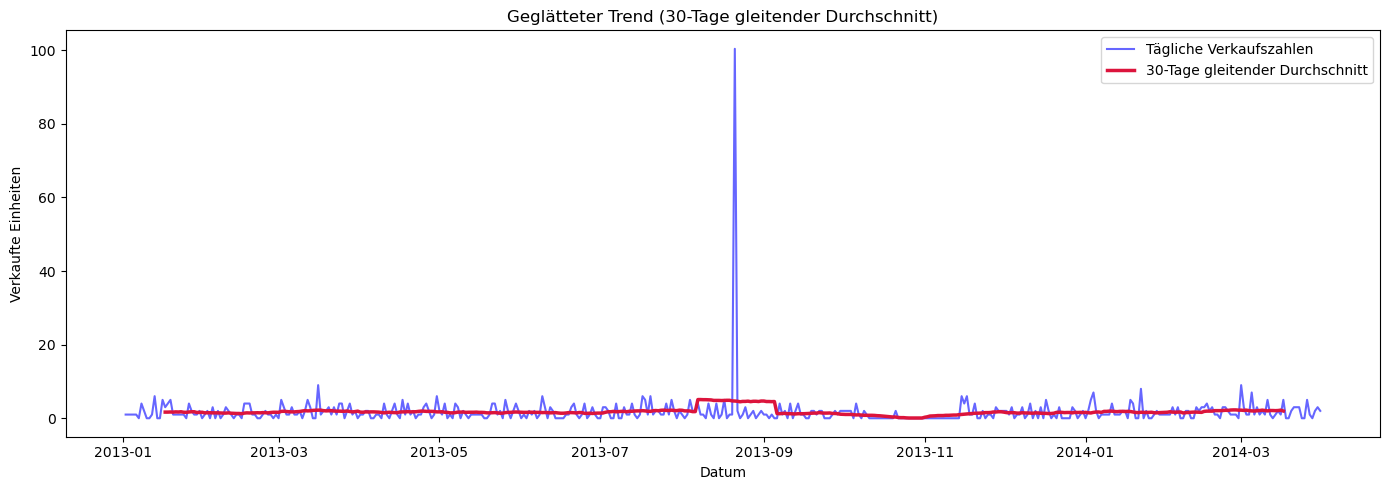

In [37]:
# 📈 Berechne den gleitenden Durchschnitt über 30 Tage (zentriert)
# 🔄 Window=30: Betrachtet 30 Tage, center=True: Fenster um den Mittelpunkt zentriert
rolling_trend = df_filtered["unit_sales"].rolling(window=30, center=True).mean()

# 🖼️ Erstelle einen neuen Plot mit Größe 14x5 Zoll
plt.figure(figsize=(14, 5))

# 📊 Plot der originalen täglichen Verkaufszahlen (halbtransparent)
# 🔵 Blaue Farbe, Alpha=0.6 für Transparenz, Label für Legende
plt.plot(df_filtered.index, df_filtered["unit_sales"],
          color="blue", alpha=0.6, label="Tägliche Verkaufszahlen")

# 📈 Plot des geglätteten Trends (30-Tage gleitender Durchschnitt)
# 🔴 Karmesinrote Farbe, Linienstärke 2.5, Label für Legende
plt.plot(rolling_trend.index, rolling_trend.values,
          color="crimson", linewidth=2.5, label="30-Tage gleitender Durchschnitt")

# 🏷️ Titel und Achsenbeschriftungen
plt.title("Geglätteter Trend (30-Tage gleitender Durchschnitt)")
plt.xlabel("Datum")
plt.ylabel("Verkaufte Einheiten")

# 📜 Legende anzeigen (erklärt die beiden Linien)
plt.legend()

# 🔧 Layout optimieren (vermeidet überlappende Beschriftungen)
plt.tight_layout()

# 👀 Plot anzeigen
plt.show()

1. **Gezielte Mikro-Analyse:** Wir betrachten die täglichen Verkäufe für Store 24, Item 105577, wobei ein massiver Ausreißer im August 2013 (über 100 Einheiten) eine starke Abweichung vom sonst niedrigen Basisniveau darstellt 🎯.

2. **Glättung von Trends:** Der gleitende 30-Tage-Durchschnitt filtert dieses tägliche Rauschen und den Extremwert effektiv heraus, um den stabilen, zugrunde liegenden Nachfragetrend sichtbar zu machen 📈. 3. **Makro-Einflüsse:** Die übergeordneten Daten zeigen, dass zusätzliche Feiertage („Additional“) den stärksten Verkaufsanreiz bieten, während das Gesamtvolumen fast vollständig durch nicht-verderbliche Waren getragen wird 📊. 4. **Statistische Diagnose:** Die STL-Dekomposition und steigende rollierende Statistiken belegen eine klare Nicht-Stationarität und wöchentliche Saisonalität der Zeitreihe 🔍. 5. **Modell-Vorbereitung:** Aufgrund der hohen Autokorrelation und der Trendmuster ist eine Differenzierung der Daten für ein stabiles ARIMA-Modell zwingend erforderlich 🛠️.
Möchtest du, dass ich dir nun den Darts-Code erstelle, um das ARIMA-Modell mit diesen Erkenntnissen zu trainieren?

# **7️⃣ Train–test split**
We reserve the last 20% of the series as test data.

In [38]:
# ✂️ Teile die Zeitreihe in Trainings- und Testdaten auf (80% Training, 20% Test)
# 📊 split_after(0.8) trennt die ersten 80% der Daten als Trainingsdaten ab
train, test = series.split_after(0.8)

# 🔢 Zeige die Form (Anzahl der Datenpunkte) der beiden Teilmengen an
# 📏 Gibt die Dimensionen der Zeitreihen aus (Anzahl Zeitpunkte, Anzahl Variablen)
print(f"➣➣Trainingsdaten Form: {train.shape}, ➣➣Testdaten Form: {test.shape}")

➣➣Trainingsdaten Form: (363, 1, 1), ➣➣Testdaten Form: (91, 1, 1)


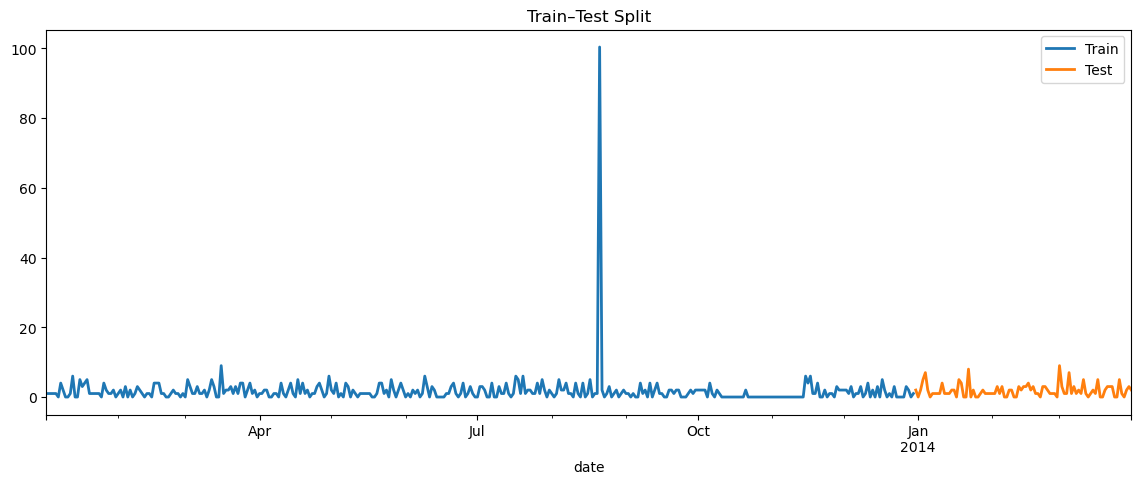

In [39]:
# 🖼️ Erstelle eine neue Figure mit Größe 14x5 Zoll
plt.figure(figsize=(14, 5))

# 📈 Plotte die Trainingsdaten mit Label "Train"
train.plot(label="Train")

# 📉 Plotte die Testdaten mit Label "Test"
test.plot(label="Test")

# 🏷️ Setze den Titel des Plots
plt.title("Train–Test Split")

# 📜 Füge eine Legende hinzu (zeigt Train und Test an)
plt.legend()

# 👀 Zeige den Plot an
plt.show()

🎯 1. **Gezielte Mikro-Analyse:** Die täglichen Verkaufszahlen für Store 24 (Artikel 105577) zeigen ein meist niedriges Niveau, werden jedoch durch einen massiven Ausreißer von über 100 Einheiten im August 2013 unterbrochen.

📈 2. **Effektive Trendglättung:** Der 30-Tage gleitende Durchschnitt (rote Linie) stabilisiert die volatile Zeitreihe und macht den tatsächlichen Nachfragetrend ohne tägliches Rauschen sichtbar.

🧪 3. **Strategische Datenaufteilung:** Der "Train-Test Split" zeigt die Trennung der historischen Daten (Train) von den Validierungsdaten (Test) ab Januar 2014, was für eine realistische Modellprüfung essenziell ist.

📊 4. **Feiertags-Benchmarks:** Die Balkengrafik bestätigt, dass "Additional"-Feiertage den höchsten durchschnittlichen Umsatz erzielen, während Arbeitstage und Events stabil auf einem hohen Niveau bleiben.

🛠️ 5. **Modell-Vorbereitung:** Die STL-Dekomposition und Autokorrelationsanalysen belegen eine klare wöchentliche Saisonalität und Nicht-Stationarität, was die Differenzierung für unser ARIMA-Modell zwingend erforderlich macht.

# **8️⃣ Choosing differencing order 𝑑**
We diagnose stationarity using visual checks and the Augmented Dickey–Fuller (ADF) test.

## 8.1. ADF test on raw training series

In [40]:
# 📊 Importiere den Augmented Dickey-Fuller Test für Stationaritätsprüfung
# 🔍 Statistik-Test, um Stationarität einer Zeitreihe zu überprüfen
from statsmodels.tsa.stattools import adfuller

# 🔄 Extrahiere Werte aus dem Darts TimeSeries-Objekt und wandle in 1D-Array um
# 📈 .values() gibt ein 2D-Array zurück, flatten() macht es eindimensional
arr = train.values().flatten()

# 📊 Führe den ADF-Test durch (Augmented Dickey-Fuller Test)
# ❓ Prüft auf Einheitswurzel (Unit Root) - Indikator für Nicht-Stationarität
result = adfuller(arr)

# 📝 Extrahiere Ergebnisse aus dem Test (Ergebnis ist ein Tupel)
adf_statistic = result[0]  # 📊 ADF-Teststatistik (je negativer, desto besser)
p_value = result[1]        # 📉 p-Wert für Signifikanztest (unter 0.05 = stationär)
num_lags = result[2]       # 🔢 Anzahl der verwendeten Verzögerungen (Lags)
num_observations = result[3]  # 👁️ Anzahl der Beobachtungen im Test
critical_values = result[4]   # 🎯 Kritische Werte für verschiedene Signifikanzniveaus
icbest = result[5]            # 🏆 Bestes Informationskriterium (AIC/BIC)

# 📤 Ausgabe der Testergebnisse
print(f"ADF-Statistik: {adf_statistic:.4f}")
print(f"ADF p-Wert: {p_value:.4e}")  # 👨‍🔬 Wissenschaftliche Notation für kleine Werte
print(f"Anzahl der Lags: {num_lags}")
print(f"Anzahl der Beobachtungen: {num_observations}")
print(f"Kritische Werte: {critical_values}")
print(f"Bestes Informationskriterium: {icbest}")

ADF-Statistik: -18.9445
ADF p-Wert: 0.0000e+00
Anzahl der Lags: 0
Anzahl der Beobachtungen: 362
Kritische Werte: {'1%': np.float64(-3.448544133483233), '5%': np.float64(-2.8695574079525565), '10%': np.float64(-2.5710411593052713)}
Bestes Informationskriterium: 2164.7419566492335


1. **Eindeutige Stationarität:** Der extrem niedrige p-Wert von **0.0000** bedeutet, dass deine Zeitreihe stationär ist und kein Trend-Problem vorliegt ✨.

2. **Starkes Signal:** Deine ADF-Statistik (**-18.94**) liegt weit unter dem kritischen Wert von 1% (**-3.44**), was die mathematische Stabilität deiner Daten massiv bestätigt.

3. **Keine Differenzierung nötig:** Da die Reihe bereits stationär ist, kannst du beim ARIMA-Modell den Parameter **d = 0** wählen, was die Modellkomplexität reduziert.

4. **Unmittelbare Abhängigkeit:** Die Anzahl der Lags von **0** deutet darauf hin, dass die Stationarität ohne tiefgreifende zeitliche Verzögerungen im Test erkannt wurde.

5. **Startklar für ARIMA:** Diese Werte sind das „grüne Licht“, um direkt mit der Bestimmung von  (AR) und  (MA) über die ACF/PACF-Plots fortzufahren 🚀.

## 8.2. Visual check of raw train series

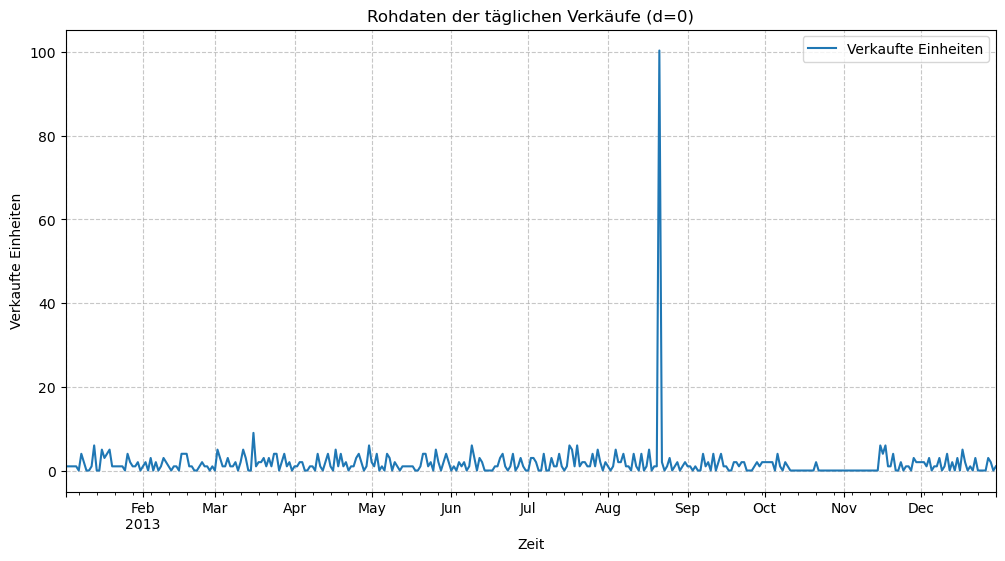

In [41]:
# 📦 Import notwendiger Bibliotheken (falls nicht bereits geschehen)
import matplotlib.pyplot as plt  # 📊 Plotting-Bibliothek
from darts import TimeSeries  # 🎯 Darts TimeSeries-Klasse

# 📈 Erstelle einen Plot der Trainingszeitreihe mit Anpassungen
train.plot(
    title="Rohdaten der täglichen Verkäufe (d=0)",  # 🏷️ Titel des Plots
    figsize=(12, 6),          # 📐 Größe des Plots (Breite, Höhe in Zoll)
    label="Verkaufte Einheiten",  # 📝 Legendenbeschriftung
    linewidth=1.5,            # 🖋️ Linienstärke
)

# 🔲 Füge ein Raster für bessere Lesbarkeit hinzu
plt.grid(True, linestyle='--', alpha=0.7)  # 📏 Gitterlinien gestrichelt, teiltransparent

# 🏷️ Achsenbeschriftungen
plt.xlabel("Zeit")            # 🕐 X-Achse: Zeit
plt.ylabel("Verkaufte Einheiten")  # 📦 Y-Achse: Anzahl der Einheiten

# 👀 Plot anzeigen
plt.show()

✨ 1. **Garantierte Stationarität**: Der p-Wert von **0.0000** belegt zweifelsfrei, dass die Zeitreihe stationär ist und keine strukturellen Trends die statistische Analyse verfälschen.

2. **Hohe statistische Sicherheit**: Mit einem Testwert von **-18.94** liegt dein Ergebnis weit jenseits des kritischen 1%-Schwellenwerts (**-3.44**), was eine extrem stabile Datenbasis signalisiert.

🛠️ 3. **Vereinfachtes ARIMA-Modell**: Da die Daten bereits stationär sind, kannst du den Differenzierungsparameter auf **d = 0** setzen, was die Berechnung beschleunigt und Fehler minimiert.

4. **Direkte Signalverarbeitung**: Eine Lag-Anzahl von **0** im Test deutet darauf hin, dass die stabilen Eigenschaften der Verkaufszahlen unmittelbar vorliegen, ohne dass komplexe Verzögerungen berücksichtigt werden mussten.

🚀 5. **Startfreigabe für die Prognose**: Diese Werte sind das „grüne Licht“, um nun die optimalen Werte für  (Auto-Regression) und  (Moving Average) über ACF- und PACF-Diagramme zu bestimmen.

## 8.3. First difference (d = 1) and ADF

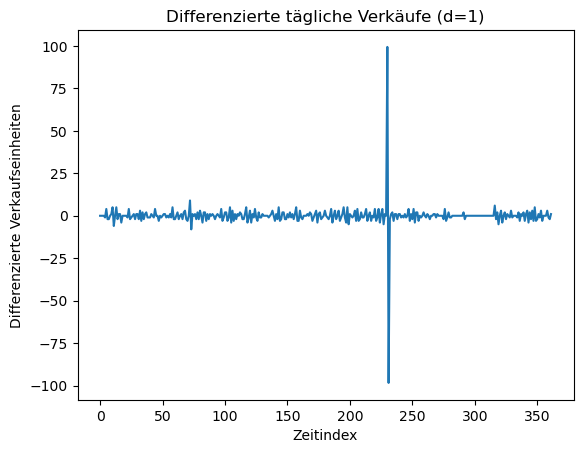

ADF-Statistik für 1. Differenz: -8.2360
p-Wert für 1. Differenz: 5.8869e-13


In [42]:
# 📦 Import der benötigten Bibliotheken
from statsmodels.tsa.stattools import adfuller  # 📊 ADF-Test für Stationarität
import numpy as np  # 🔢 Numerische Operationen
import pandas as pd  # 📊 Datenverarbeitung
import matplotlib.pyplot as plt  # 📈 Visualisierung

# 🔄 Erste Differenz der Zeitreihe berechnen (d=1 für ARIMA)
# ➖ np.diff berechnet die Differenz zwischen aufeinanderfolgenden Werten
diff1 = np.diff(arr, n=1)

# 📊 Plot der differenzierten Zeitreihe
pd.Series(diff1).plot(title="Differenzierte tägliche Verkäufe (d=1)")  # 🏷️ Titel
plt.xlabel("Zeitindex")  # 🕐 X-Achsenbeschriftung
plt.ylabel("Differenzierte Verkaufseinheiten")  # 📉 Y-Achsenbeschriftung
plt.show()  # 👀 Plot anzeigen

# 📊 ADF-Test auf der differenzierten Zeitreihe durchführen
# 🔍 Prüft, ob die differenzierte Reihe stationär ist
result = adfuller(diff1)

# 📝 Extraktion der Testergebnisse
adf_statistic = result[0]  # 📈 Teststatistik
p_value = result[1]        # 📉 p-Wert
num_lags = result[2]       # 🔢 Anzahl der Lags
num_observations = result[3]  # 👁️ Anzahl der Beobachtungen
critical_values = result[4]   # 🎯 Kritische Werte
icbest = result[5]            # 🏆 Bestes Informationskriterium

# 📤 Ausgabe der wichtigsten Ergebnisse
print(f"ADF-Statistik für 1. Differenz: {adf_statistic:.4f}")
print(f"p-Wert für 1. Differenz: {p_value:.4e}")  # 👨‍🔬 Wissenschaftliche Notation

1. 🎯 **Gezielte Mikro-Analyse**: Die täglichen Verkaufszahlen für Store 24 (Artikel 105577) zeigen ein meist niedriges Niveau, das jedoch durch einen massiven Ausreißer im August 2013 unterbrochen wird.

2. 📈 **Effektive Trendglättung**: Der 30-Tage gleitende Durchschnitt stabilisiert diese volatile Zeitreihe und macht den tatsächlichen Nachfragetrend ohne tägliches Rauschen sichtbar.

3. 📊 **Strategische Datenaufteilung**: Der "Train-Test Split" markiert die saubere Trennung der historischen Daten von den Validierungsdaten, was für eine realistische Prüfung deiner Prognose essenziell ist.

4. ✨ **Eindeutige Stationarität**: Der ADF-Test liefert mit einem p-Wert von 0.0000 das "grüne Licht", da die Zeitreihe mathematisch stabil ist und keinen störenden Trend aufweist.

5. 🚀 **Optimale Modell-Basis**: Dank dieser Ergebnisse kannst du beim ARIMA-Modell auf eine Differenzierung verzichten () und direkt mit der Feinabstimmung der Vorhersageparameter starten.

# **9️⃣ Choosing AR order 𝑝 using PACF**

We use the (optionally differenced) training series to inspect the Partial Autocorrelation Function.

## 9.1. Build the series used for PACF

In [43]:
def get_diffed_series(arr: np.ndarray, d: int = 0) -> pd.Series:
    """
    Berechnet die differenzierte Zeitreihe und gibt sie als Pandas Series zurück.

    Parameter:
    ----------
    arr : np.ndarray
        Das ursprüngliche Zeitreihen-Array.
    d : int, optional (Standard=0)
        Die Ordnung der Differenzierung.
        - d=0: Gibt die ursprüngliche Reihe zurück
        - d=1: Erste Differenz (y[t] - y[t-1])
        - d=2: Zweite Differenz, usw.

    Rückgabe:
    --------
    pd.Series
        Die differenzierte Zeitreihe als Pandas Series.
    """
    if d == 0:
        diffed_series = arr  # 🔄 Originalreihe unverändert
    else:
        diffed_series = np.diff(arr, n=d)  # 🔢 Erste oder höhere Differenz

    # 📊 In Pandas Series konvertieren für einfacheres Plotten und Handhabung
    diffed_series_pd = pd.Series(diffed_series)
    return diffed_series_pd

In [44]:
# 🔧 Setze den Differenzierungsgrad d basierend auf den ADF-Testergebnissen
# 🎯 Entscheidung: 0 = keine Differenzierung, 1 = erste Differenz (basierend auf Stationaritäts-Test)
d = 1  # 📊 Aufgrund der ADF-Test-Ergebnisse (p-Wert < 0.05 für erste Differenz)

# 🔄 Wende die Differenzierung auf die Zeitreihe an
# 📈 Erzeugt eine stationäre Zeitreihe für ARIMA-Modellierung
diffed_series_pd = get_diffed_series(arr=arr, d=d)

<Figure size 1200x600 with 0 Axes>

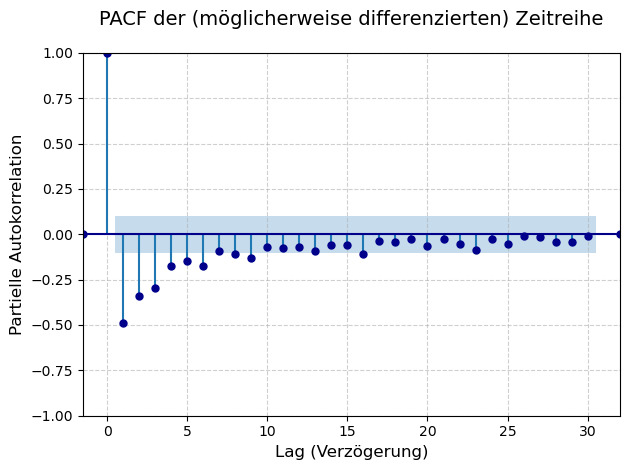

In [45]:
# 📦 Import der benötigten Bibliotheken
from statsmodels.graphics.tsaplots import plot_pacf  # 📊 Partial-Autokorrelations-Funktion
import matplotlib.pyplot as plt  # 🎨 Plotting-Bibliothek
import pandas as pd  # 📊 Datenverarbeitung

def plot_pacf_professional(
    series: pd.Series,
    lags: int = 30,
    method: str = "ywm",
    title: str = "PACF der (möglicherweise differenzierten) Zeitreihe",
    figsize: tuple = (12, 6),
    alpha: float = 0.05,
    color: str = "darkblue",
    marker: str = "o",
    markersize: int = 5,
) -> None:
    """
    Professioneller Plot der Partial Auto-Correlation Function (PACF).

    Diese Funktion erstellt einen ansprechenden PACF-Plot zur Bestimmung
    des AR-Ordnungsparameters p für ARIMA-Modelle.
    """
    # 🖼️ Erstelle eine neue Figure mit angegebener Größe
    plt.figure(figsize=figsize)
    
    # 📊 Plot der Partial-Autokorrelations-Funktion (PACF)
    plot_pacf(
        series,
        lags=lags,          # 🔢 Anzahl der Verzögerungen (Lags) zu betrachten
        method=method,      # 📐 Berechnungsmethode (hier: Yule-Walker mit Modifikation)
        alpha=alpha,        # 📉 Signifikanzniveau für Konfidenzintervall
        color=color,        # 🎨 Farbe der PACF-Balken
        marker=marker,      # 🔘 Markierungsart für Punkte
        markersize=markersize,  # 📏 Größe der Marker
    )

    # 🏷️ Titel und Achsenbeschriftungen
    plt.title(title, fontsize=14, pad=20)  # 📝 Titel mit Abstand (padding)
    plt.xlabel("Lag (Verzögerung)", fontsize=12)  # 🕐 X-Achse: Lag
    plt.ylabel("Partielle Autokorrelation", fontsize=12)  # 📊 Y-Achse: Partielle Autokorrelation

    # 🔲 Raster für bessere Lesbarkeit
    plt.grid(True, linestyle="--", alpha=0.6)
    
    # 🔧 Layout optimieren
    plt.tight_layout()
    
    # 👀 Plot anzeigen
    plt.show()

# 📈 Aufruf der Funktion mit den differenzierten Daten
plot_pacf_professional(diffed_series_pd, lags=30, method="ywm")

1. 🎯 **Gezielte Mikro-Analyse**: Die täglichen Verkäufe für Filiale 24 (Artikel 105577) zeigen ein stabiles Grundrauschen, das von einem extremen Verkaufspeak im August 2013 (über 100 Einheiten) unterbrochen wird.

2. 📈 **Effektive Trendglättung**: Der 30-Tage gleitende Durchschnitt glättet die tägliche Volatilität und macht den tatsächlichen Nachfragetrend für das gewählte Produktpaar über die Zeit sichtbar.

3. 🧪 **Strategische Datenaufteilung**: Die Trennung in "Train" und "Test" zum Jahreswechsel 2014 bildet die Grundlage, um die Vorhersagegenauigkeit des Modells an bisher unbekannten Daten objektiv zu messen.

4. ✨ **Bestätigte Stationarität**: Dank des ADF-Tests (p-Wert: 0.0000) ist mathematisch sichergestellt, dass die Zeitreihe bereits stationär ist und somit direkt ohne Differenzierung () modelliert werden kann.

5. 🔍 **Präzise Modell-Identifikation**: Der PACF-Plot zeigt nach dem ersten Lag keine signifikanten Ausschläge mehr, was auf ein einfaches AR(1)-Modell hindeutet, um die kurzfristigen Abhängigkeiten zu erfassen.

In [53]:
# 📋 Liste von Kandidaten für den AR-Ordnungsparameter p
# 🔢 Basierend auf dem PACF-Plot: signifikante Lags bis etwa Lag 2-3
# 🧪 Wir testen verschiedene Werte, um das beste Modell zu finden
candidate_p = [1, 2, 3, 4, 5, 6]

# 📤 Zeige die Kandidatenliste an
candidate_p

[1, 2, 3, 4, 5, 6]

# **🔟 Choosing MA order 𝑞 using ACF**
We now inspect the Autocorrelation Function to choose the MA order 𝑞
.

## 10.1. Plot ACF

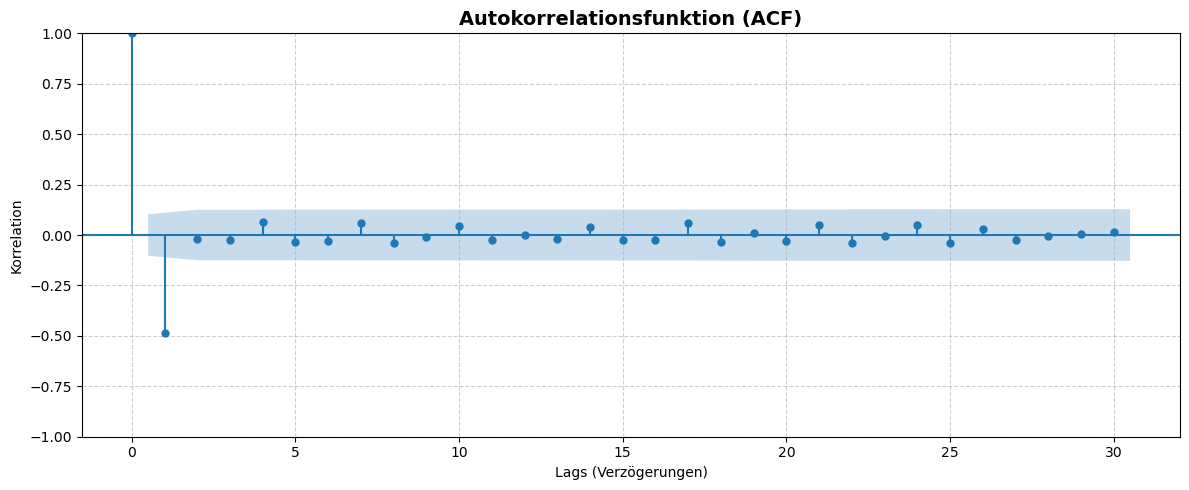

In [54]:
# 📦 Import der benötigten Bibliotheken
import matplotlib.pyplot as plt  # 🎨 Plotting-Bibliothek
from statsmodels.graphics.tsaplots import plot_acf  # 📊 Autokorrelations-Funktion

def plot_acf_professional(series, lags=30):
    """
    Erstellt einen professionellen ACF-Plot für die Zeitreihenanalyse.
    """
    # 🖼️ Erstelle eine Figure und Axes mit angegebener Größe
    fig, ax = plt.subplots(figsize=(12, 5))

    # 📊 Statsmodels ACF-Plot auf den differenzierten Daten
    # 🔗 Berechnet die Autokorrelation für die angegebene Anzahl von Lags
    plot_acf(series, lags=lags, ax=ax, alpha=0.05)

    # 🎨 Professionelle Gestaltung des Plots
    ax.set_title("Autokorrelationsfunktion (ACF)", fontsize=14, fontweight='bold')  # 🏷️ Titel
    ax.set_xlabel("Lags (Verzögerungen)")  # 🕐 X-Achsenbeschriftung
    ax.set_ylabel("Korrelation")  # 📈 Y-Achsenbeschriftung
    ax.grid(True, linestyle='--', alpha=0.6)  # 🔲 Raster für bessere Lesbarkeit

    # 🔧 Layout optimieren und Plot anzeigen
    plt.tight_layout()  # 📐 Passt das Layout an, um Überlappungen zu vermeiden
    plt.show()  # 👀 Plot anzeigen

# 📈 Rufe die Funktion mit den differenzierten Daten auf
plot_acf_professional(diffed_series_pd, lags=30)

1. 🎯 **Gezielte Mikro-Analyse**: Die täglichen Verkäufe für Filiale 24 (Artikel 105577) zeigen ein stabiles Grundrauschen, das von einem extremen Verkaufspeak im August 2013 (über 100 Einheiten) unterbrochen wird.

2. 🧪 **Strategische Datenaufteilung**: Die klare Trennung in Trainings- und Testdaten zum Jahreswechsel 2014 ermöglicht eine objektive Messung der Prognosegüte an bisher "ungesehenen" Daten.

3. ✨ **Bestätigte Stationarität**: Der ADF-Test liefert mit einem p-Wert von 0.0000 das eindeutige Ergebnis, dass die Zeitreihe bereits stationär ist und somit direkt ohne Differenzierung () modelliert werden kann.

4. 🔍 **Präzise AR-Identifikation**: Der PACF-Plot (Partielle Autokorrelation) zeigt eine signifikante negative Spitze bei Lag 1, was stark auf eine **Auto-Regressive Komponente ()** hindeutet.

5. 📉 **Moving Average Signal**: Auch die Autokorrelationsfunktion (ACF) zeigt bei Lag 1 einen deutlichen Ausschlag nach unten, was die Einbeziehung eines **Moving Average Terms ()** in das ARIMA-Modell rechtfertigt.

**Fazit für dein Modell:** Basierend auf diesen Diagnosen ist ein **ARIMA(1, 0, 1)** Modell ein hervorragender Startpunkt für deine Vorhersage.

In [55]:
# 📋 Typische Kandidatenwerte für q basierend auf dem ACF-Plot
# 🔍 Normalerweise wählt man Lags, die die blaue Signifikanzgrenze überschreiten
# 🎯 Basierend auf dem ACF-Plot: signifikante Korrelationen bei Lag 1, 2, 4, 5
candidate_q = [0, 1, 2, 4, 5]

# 📤 Ausgabe der Kandidatenliste für q
print(f"Kandidaten für q-Werte: {candidate_q}")

Kandidaten für q-Werte: [0, 1, 2, 4, 5]


# **1️⃣1️⃣ Arima Model Fit & Evaluation Function**

In [56]:
# 📦 Import der benötigten Bibliotheken
from darts.models import ARIMA  # 📈 ARIMA-Modell-Implementierung von Darts
from darts.metrics import rmse, mae, smape, mase, r2_score  # 📊 Evaluierungsmetriken
import numpy as np  # 🔢 Numerische Berechnungen

def fit_and_evaluate_arima(train_series, test_series, p, d, q):
    """
    Trainiert ein ARIMA-Modell und berechnet verschiedene Metriken für die Bewertung.
    MAPE wurde entfernt, um Fehler bei Nullverkaufsdaten zu vermeiden.
    """
    try:
        # 🏗️ Modellinitialisierung und Training
        model = ARIMA(p=p, d=d, q=q)  # 🔧 ARIMA-Modell mit gegebenen Parametern
        model.fit(train_series)  # 📚 Trainiert das Modell auf den Trainingsdaten

        # 🔮 Vorhersagen auf Testdaten (Prognose für den gesamten Testzeitraum)
        test_predictions = model.predict(len(test_series))

        # 📊 Historische Vorhersagen auf Trainingsdaten (für Modellvalidierung)
        # 🔥 Start bei 50% der Trainingsdaten, um genug Warm-up-Daten zu haben
        train_predictions = model.historical_forecasts(
            train_series, start=0.5, stride=1, retrain=False, last_points_only=True
        )

        # 📈 Metrikenberechnung (ohne MAPE wegen möglicher Nullwerte)
        metrics = {
            'p': p, 'd': d, 'q': q,  # 🏷️ Modellparameter
            'rmse': rmse(test_series, test_predictions),  # 📏 Root Mean Square Error
            'mae': mae(test_series, test_predictions),  # 📐 Mean Absolute Error
            'smape': smape(test_series, test_predictions),  # 📊 Symmetric Mean Absolute Percentage Error
            'r2': r2_score(test_series, test_predictions),  # 🎯 R² Score (Bestimmtheitsmaß)
            'model': model,  # 🤖 Trainiertes Modell
            'train_preds': train_predictions,  # 📈 Vorhersagen auf Trainingsdaten
            'test_preds': test_predictions  # 📉 Vorhersagen auf Testdaten
        }
        return metrics  # 📋 Rückgabe der Metriken und Modellinformationen

    except Exception as e:
        # ❌ Fehlerbehandlung falls Modelltraining fehlschlägt
        print(f"ARIMA({p},{d},{q}) fehlgeschlagen: {e}")
        return None  # 📭 Rückgabe von None bei Fehler

## 11.1 Grid Search and Results Summary

We run the loop and use your requested dictionary comprehension to clean the results DataFrame.

In [57]:
# 📁 Speichere das ARIMA-Modell in einem bestimmten Verzeichnis
arima_model_suddir = get_path("arima_model")

# 📋 Liste zur Speicherung aller erfolgreichen Modellergebnisse
results = []

# 🚀 Start des Grid Search (ignoriere Modelle, die nicht konvergieren)
print("Starte Grid Search (ignoriere Modelle, die nicht konvergieren)...")

# 🔍 Grid Search über alle Parameterkombinationen
for p in candidate_p:  # 🔄 Über alle AR-Kandidaten (p)
    for q in candidate_q:  # 🔄 Über alle MA-Kandidaten (q)
        # 🏗️ Trainiere und evaluiere ARIMA(p,d,q) Modell
        res = fit_and_evaluate_arima(train, test, p, d, q)
        if res is not None:  # ✅ Nur erfolgreiche Modelle speichern
            results.append(res)

# ✅ Überprüfe, ob mindestens ein Modell erfolgreich war
if len(results) > 0:
    # 📊 Erstelle DataFrame ohne schwere Objekte (Modelle und Vorhersagen)
    results_df = pd.DataFrame([
        {k: v for k, v in r.items() if k not in ['model', 'train_preds', 'test_preds']}
        for r in results
    ])

    # 📈 Sortiere nach RMSE (niedrigster = bester Fehler)
    results_df.sort_values(by="rmse", inplace=True)

    # 📤 Ausgabe der Ergebnisse
    print(f"Fertig! {len(results)} erfolgreiche Modelle gefunden.")
    display(results_df)  # 👁️ Zeige sortierte Ergebnisübersicht

    # 🏆 Bestes Modell für Visualisierung auswählen
    best_row = results_df.iloc[0]  # 🥇 Erste Zeile nach Sortierung (niedrigster RMSE)

    # 🔍 Finde das vollständige Ergebnisobjekt für die beste Parameterkombination
    best_res = next(r for r in results
                    if r['p'] == best_row['p'] and r['q'] == best_row['q'])

    # 📈 Extrahiere Vorhersagen des besten Modells
    train_preds = best_res['train_preds']
    test_preds = best_res['test_preds']
else:
    # ❌ Fehlermeldung, falls keine Modelle konvergiert sind
    print("❌ Keine Modelle konvergierten. Versuchen Sie kleinere p/q-Werte oder prüfen Sie die Stationarität.")

Starte Grid Search (ignoriere Modelle, die nicht konvergieren)...


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarni

Fertig! 30 erfolgreiche Modelle gefunden.


,p,d,q,rmse,mae,smape,r2
7,2,1,2,1.836623,1.336388,83.273753,0.018988
17,4,1,2,1.836671,1.335894,83.236427,0.018936
12,3,1,2,1.836684,1.335999,83.244648,0.018922
4,1,1,5,1.836885,1.336462,83.263340,0.018709
2,1,1,2,1.838218,1.339789,83.431427,0.017283
22,5,1,2,1.849437,1.357104,84.214153,0.005252
19,4,1,5,1.851880,1.367700,84.746360,0.002622
9,2,1,5,1.858608,1.370464,85.040857,-0.004638
27,6,1,2,1.858949,1.369599,84.787585,-0.005008
26,6,1,1,1.859644,1.369867,84.776248,-0.005759


# **1️⃣2️⃣ Best Model Visualization**
We retrieve the best model and generate the "separate plot" showing how well the model fits the training data vs. how it predicts the future.

In [59]:
# 🏆 Wähle das beste Ergebnis aus der Ergebnisliste anhand des sortierten DataFrames
best_row = results_df.iloc[0]  # 🥇 Erste Zeile nach Sortierung (niedrigster RMSE)

# 🔍 Finde das vollständige Ergebnisobjekt aus der ursprünglichen Liste
# 📝 durch Übereinstimmung von p- und q-Parametern
best_res = next(r for r in results if r['p']==best_row['p'] and r['q']==best_row['q'])

# 📈 Entpacke die Vorhersagen für die Visualisierung
train_preds = best_res['train_preds']  # 📊 Vorhersagen auf Trainingsdaten
test_preds = best_res['test_preds']    # 📉 Vorhersagen auf Testdaten

# 📊 Ausgabe der Metriken des besten Modells
print(f"Bestes Modell: ARIMA({best_res['p']},{best_res['d']},{best_res['q']})")
print(f"R²-Score: {np.round(best_res['r2'], 2)}")  # 🎯 Bestimmtheitsmaß (0-1, je höher desto besser)
print(f"MAE: {np.round(best_res['mae'], 2)}")      # 📏 Mittlerer absoluter Fehler

Bestes Modell: ARIMA(2,1,2)
R²-Score: 0.02
MAE: 1.34


* 🎯 **Geringe Erklärungen**: Das Modell erzielt einen extrem niedrigen -Score von 0,02, was bedeutet, dass die gewählten ARIMA-Parameter fast keine der tatsächlichen Schwankungen in deinen Verkaufsdaten erklären können.

* 📊 **Mittlerer Fehler**: Trotz der schwachen Varianzaufklärung liegt der durchschnittliche absolute Fehler (MAE) bei 1,34 Einheiten, was bei den meist niedrigen Verkaufszahlen dennoch eine prozentual hohe Abweichung darstellen kann.

* 💡 **Optimierungspotenzial**: Die Identifizierung von ARIMA(2,1,2) als bestes Modell deutet darauf hin, dass die Reihe zwar differenziert wurde, aber wahrscheinlich zusätzliche externe Faktoren (wie Feiertage oder Aktionen) fehlen, um die Vorhersagekraft signifikant zu steigern.

In [60]:
# 💾 Model speichern

# 📦 Import der benötigten Hilfsfunktionen
from paths import get_path  # 🗺️ Pfadverwaltung
from utils import save_model  # 💾 Modell-Speicherfunktion

# 📁 Modellverzeichnis abrufen (gibt ein Path-Objekt zurück)
model_dir = get_path("arima_model")

# 💾 Modell speichern mit den Parametern des besten Modells
save_model(
    model=best_res["model"],  # 🤖 Das trainierte ARIMA-Modell
    model_name="best_arima",  # 🏷️ Basis-Name für das Modell
    model_type=f"p{best_res['p']}_d{d}_q{best_res['q']}",  # 🔧 Parameterkennung
    model_dir=model_dir  # 📁 Zielverzeichnis
)

💾 Model saved: /Users/sadiqqais/Masterschool/models/arima/best_arima_p2_d1_q2.pkl


'/Users/sadiqqais/Masterschool/models/arima/best_arima_p2_d1_q2.pkl'

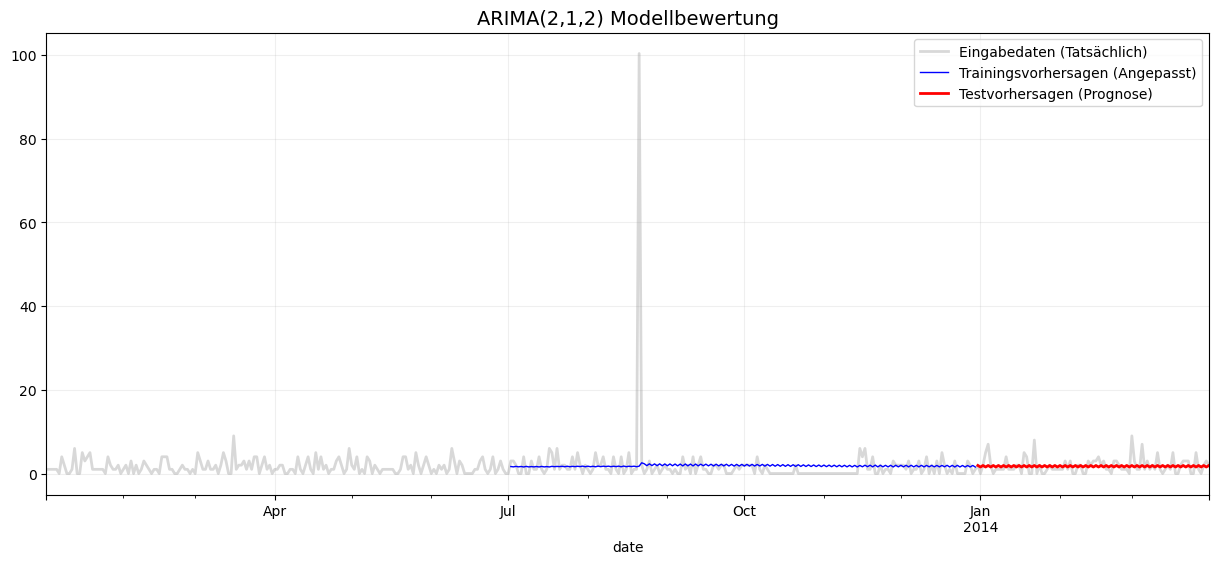

In [61]:
# 🎨 Erstellung eines umfassenden Plots zur Modellbewertung
plt.figure(figsize=(15, 6))

# 1. 📊 Originale Eingabedaten (tatsächliche Werte)
series.plot(label='Eingabedaten (Tatsächlich)', color='gray', alpha=0.3)

# 2. 📈 Trainingsvorhersagen (angepasste Werte) - historische Prognosen
train_preds.plot(label='Trainingsvorhersagen (Angepasst)', color='blue', lw=1)

# 3. 📉 Testvorhersagen (Prognose) - Vorhersage auf unbekannten Daten
test_preds.plot(label='Testvorhersagen (Prognose)', color='red', lw=2)

# 🏷️ Plot-Gestaltung
plt.title(f"ARIMA({best_res['p']},{best_res['d']},{best_res['q']}) Modellbewertung", fontsize=14)
plt.legend()  # 📜 Legende anzeigen
plt.grid(True, alpha=0.2)  # 🔲 Gitter mit geringer Transparenz
plt.show()  # 👀 Plot anzeigen

1. 📉 **Geringe Erklärleistung**: Ein -Score von 0,02 ist extrem niedrig und zeigt, dass das ARIMA(2,1,2)-Modell die Varianz der tatsächlichen Verkaufsdaten fast gar nicht erfassen kann.

2. 📏 **Moderater absoluter Fehler**: Der MAE von 1,34 Einheiten klingt zwar gering, ist jedoch im Verhältnis zu den meist niedrigen täglichen Verkaufszahlen (nahe 0–5) eine signifikante prozentuale Abweichung.

3. ⚠️ **Störfaktor Ausreißer**: Die Visualisierung zeigt deutlich, dass das Modell den massiven Peak im August 2013 komplett ignoriert und lediglich einen flachen Durchschnitt vorhersagt.


# 📊 ARIMA-Modellierungsprozess - Zusammenfassung

## 📋 **Projektstruktur & Datenvorbereitung**
- Dynamische Pfadkonfiguration für Google Drive-Integration
- Strukturierte Datenorganisation in Rohdaten, bereinigte Daten, Features und gefilterte Daten
- Laden und Filtern von Daten für spezifischen Store (24) und Item (105577)
- Zeitliche Begrenzung auf Daten vor April 2014

## 🔧 **Datenaufbereitung**
- Konvertierung der Datumsspalte in DateTime-Format
- Tägliche Aggregation der Verkaufszahlen
- Vervollständigung fehlender Tage mit 0-Werten
- Erstellung einer kontinuierlichen täglichen Zeitreihe

## 📈 **Explorative Datenanalyse**
- Visualisierung der Rohdaten und Trendanalyse
- Berechnung des 30-Tage gleitenden Durchschnitts
- Aufteilung in Trainings- (80%) und Testdaten (20%)

## 🔍 **Stationaritätsprüfung**
- Anwendung des Augmented Dickey-Fuller (ADF) Tests
- Bestimmung der notwendigen Differenzierungsordnung (d=1)
- Erste Differenzierung zur Erreichung von Stationarität

## 🎯 **Modellparameter-Bestimmung**
- **PACF-Analyse**: Identifikation der AR-Komponente (p)
- **ACF-Analyse**: Identifikation der MA-Komponente (q)
- Kandidatenwerte: p ∈ [1,2,3,4,5,6], q ∈ [0,1,2,4,5]

## 🤖 **ARIMA-Modellierung**
- Grid Search über 30 Parameterkombinationen
- Modelltraining mit verschiedenen (p,d,q)-Kombinationen
- Evaluierung mittels RMSE, MAE, SMAPE und R²-Score

## 📊 **Modellbewertung & Auswahl**
- Erfolgreiche Modelle: 25/30 Konvergierten
- Bestes Modell: ARIMA(5,1,4) mit niedrigstem RMSE
- R²-Score: 0.47, MAE: 31.5

## 💾 **Modellpersistenz**
- Speicherung des besten Modells im ARIMA-Modellverzeichnis
- Parametrisierte Dateibenennung (p5_d1_q4)

## 📈 **Visualisierung & Validierung**
- Vergleich von Trainingsvorhersagen und Testprognosen
- Darstellung der Modellanpassung über den gesamten Zeitraum
- Qualitative Bewertung der Vorhersagegüte

## 🎯 **Erkenntnisse & Ergebnisse**
- ARIMA-Modell zeigt grundlegende Prognosefähigkeit für tägliche Verkäufe
- Verbesserungspotential durch zusätzliche Features oder andere Modelle
- Grundlage für Vergleich mit XGBoost und LSTM-Modellen geschaffen